In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image

import requests
from PIL import Image
import numpy as np
from io import BytesIO
import os



In [2]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_15584\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [ ]:
bp_track_media = pd.read_csv('data/bp_track_media.csv')

In [73]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [74]:
bp_genre.head()

,genre_id,genre_name,song_count,genre_url,updated_on
0,8,Hard Dance / Hardcore,178646,/genre/hard-dance-hardcore/8,2023-09-19 15:01:03
1,50,Nu Disco / Disco,157934,/genre/nu-disco-disco/50,2023-09-19 15:01:03
2,12,Deep House,897280,/genre/deep-house/12,2023-09-19 15:01:03
3,85,Bass / Club,20716,/genre/bass-club/85,2023-09-19 15:01:03
4,94,Electro (Classic / Detroit / Modern),19615,/genre/electro-classic-detroit-modern/94,2023-09-19 15:01:03


In [ ]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

# Display the first few rows to verify
bp_media.head()

In [75]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [3]:
bp_track.drop(columns=['track_id', 'title', 'mix', 'is_remixed', 'release_date', 'track_url', 'duration', 'isrc', 'updated_on', 'is_matched_spot', 'subgenre_id'], inplace=True, axis=1)

In [4]:
bp_track.isnull().sum()

genre_id          0
bpm               0
duration_ms    2632
key_id         6254
label_id          0
release_id        0
dtype: int64

In [5]:
bp_track = bp_track.dropna()

In [9]:
# Define your desired sample size for each class
sample_size = 5000  # Adjust this to your desired sample size

# Get the minimum count of samples available across all genres
min_count = bp_track['genre_id'].value_counts().min()

# Ensure the sample size does not exceed the minimum class size
sample_size_per_class = min(sample_size, min_count)

# Sample from each genre
bp_sample = bp_track.groupby('genre_id').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)

# Display the balanced sample
bp_sample.head()

C:\Users\Shank\AppData\Local\Temp\ipykernel_15584\2565442244.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_sample = bp_track.groupby('genre_id').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)


,genre_id,bpm,duration_ms,key_id,label_id,release_id
0,1,87,400024.0,9.0,7689,841739
1,1,88,321818.0,34.0,27976,4206652
2,1,87,347586.0,19.0,75435,2505796
3,1,88,250087.0,5.0,52548,2096738
4,1,78,382866.0,33.0,17012,312636


In [10]:
features = bp_sample.drop(columns='genre_id')

In [11]:
X = features
y = bp_sample['genre_id']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [13]:
def train_and_evaluate_model(models):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    results = {}

    for model in models:
        model_scores = {}
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute each metric
        for metric_name, metric_function in metrics.items():
            if metric_name == 'ROC AUC':
                # For binary or multiclass classification, use the predict_proba method
                if hasattr(model, "predict_proba"):
                    y_pred_prob = model.predict_proba(X_test)
                    if y_pred_prob.shape[1] == 2:
                        # Binary classification case
                        score = metric_function(y_test, y_pred_prob[:, 1])
                    else:
                        # Multiclass case
                        score = metric_function(y_test, y_pred_prob, multi_class='ovr')
                else:
                    score = "N/A"  # In case model does not support predict_proba
            else:
                # For multiclass classification, use 'weighted' average
                if metric_name in ['Precision', 'Recall', 'F1 Score']:
                    score = metric_function(y_test, y_pred, average='weighted')
                else:
                    score = metric_function(y_test, y_pred)

            model_scores[metric_name] = score

        results[str(model)] = model_scores

    return results


In [14]:
models = [
    LogisticRegression(),               # Linear model
    RandomForestClassifier(),           # Ensemble of decision trees
    GradientBoostingClassifier(),       # Boosting method
    AdaBoostClassifier(),               # Boosting method
    BaggingClassifier(),                # Bagging method
    KNeighborsClassifier(),             # k-NN classifier
    DecisionTreeClassifier(),           # Simple decision tree
    ExtraTreesClassifier()
    ]
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defaul

C:\Users\Shank\AppData\Local\Temp\ipykernel_15584\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_15584\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_15584\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_15584\391156369.py:26: Use

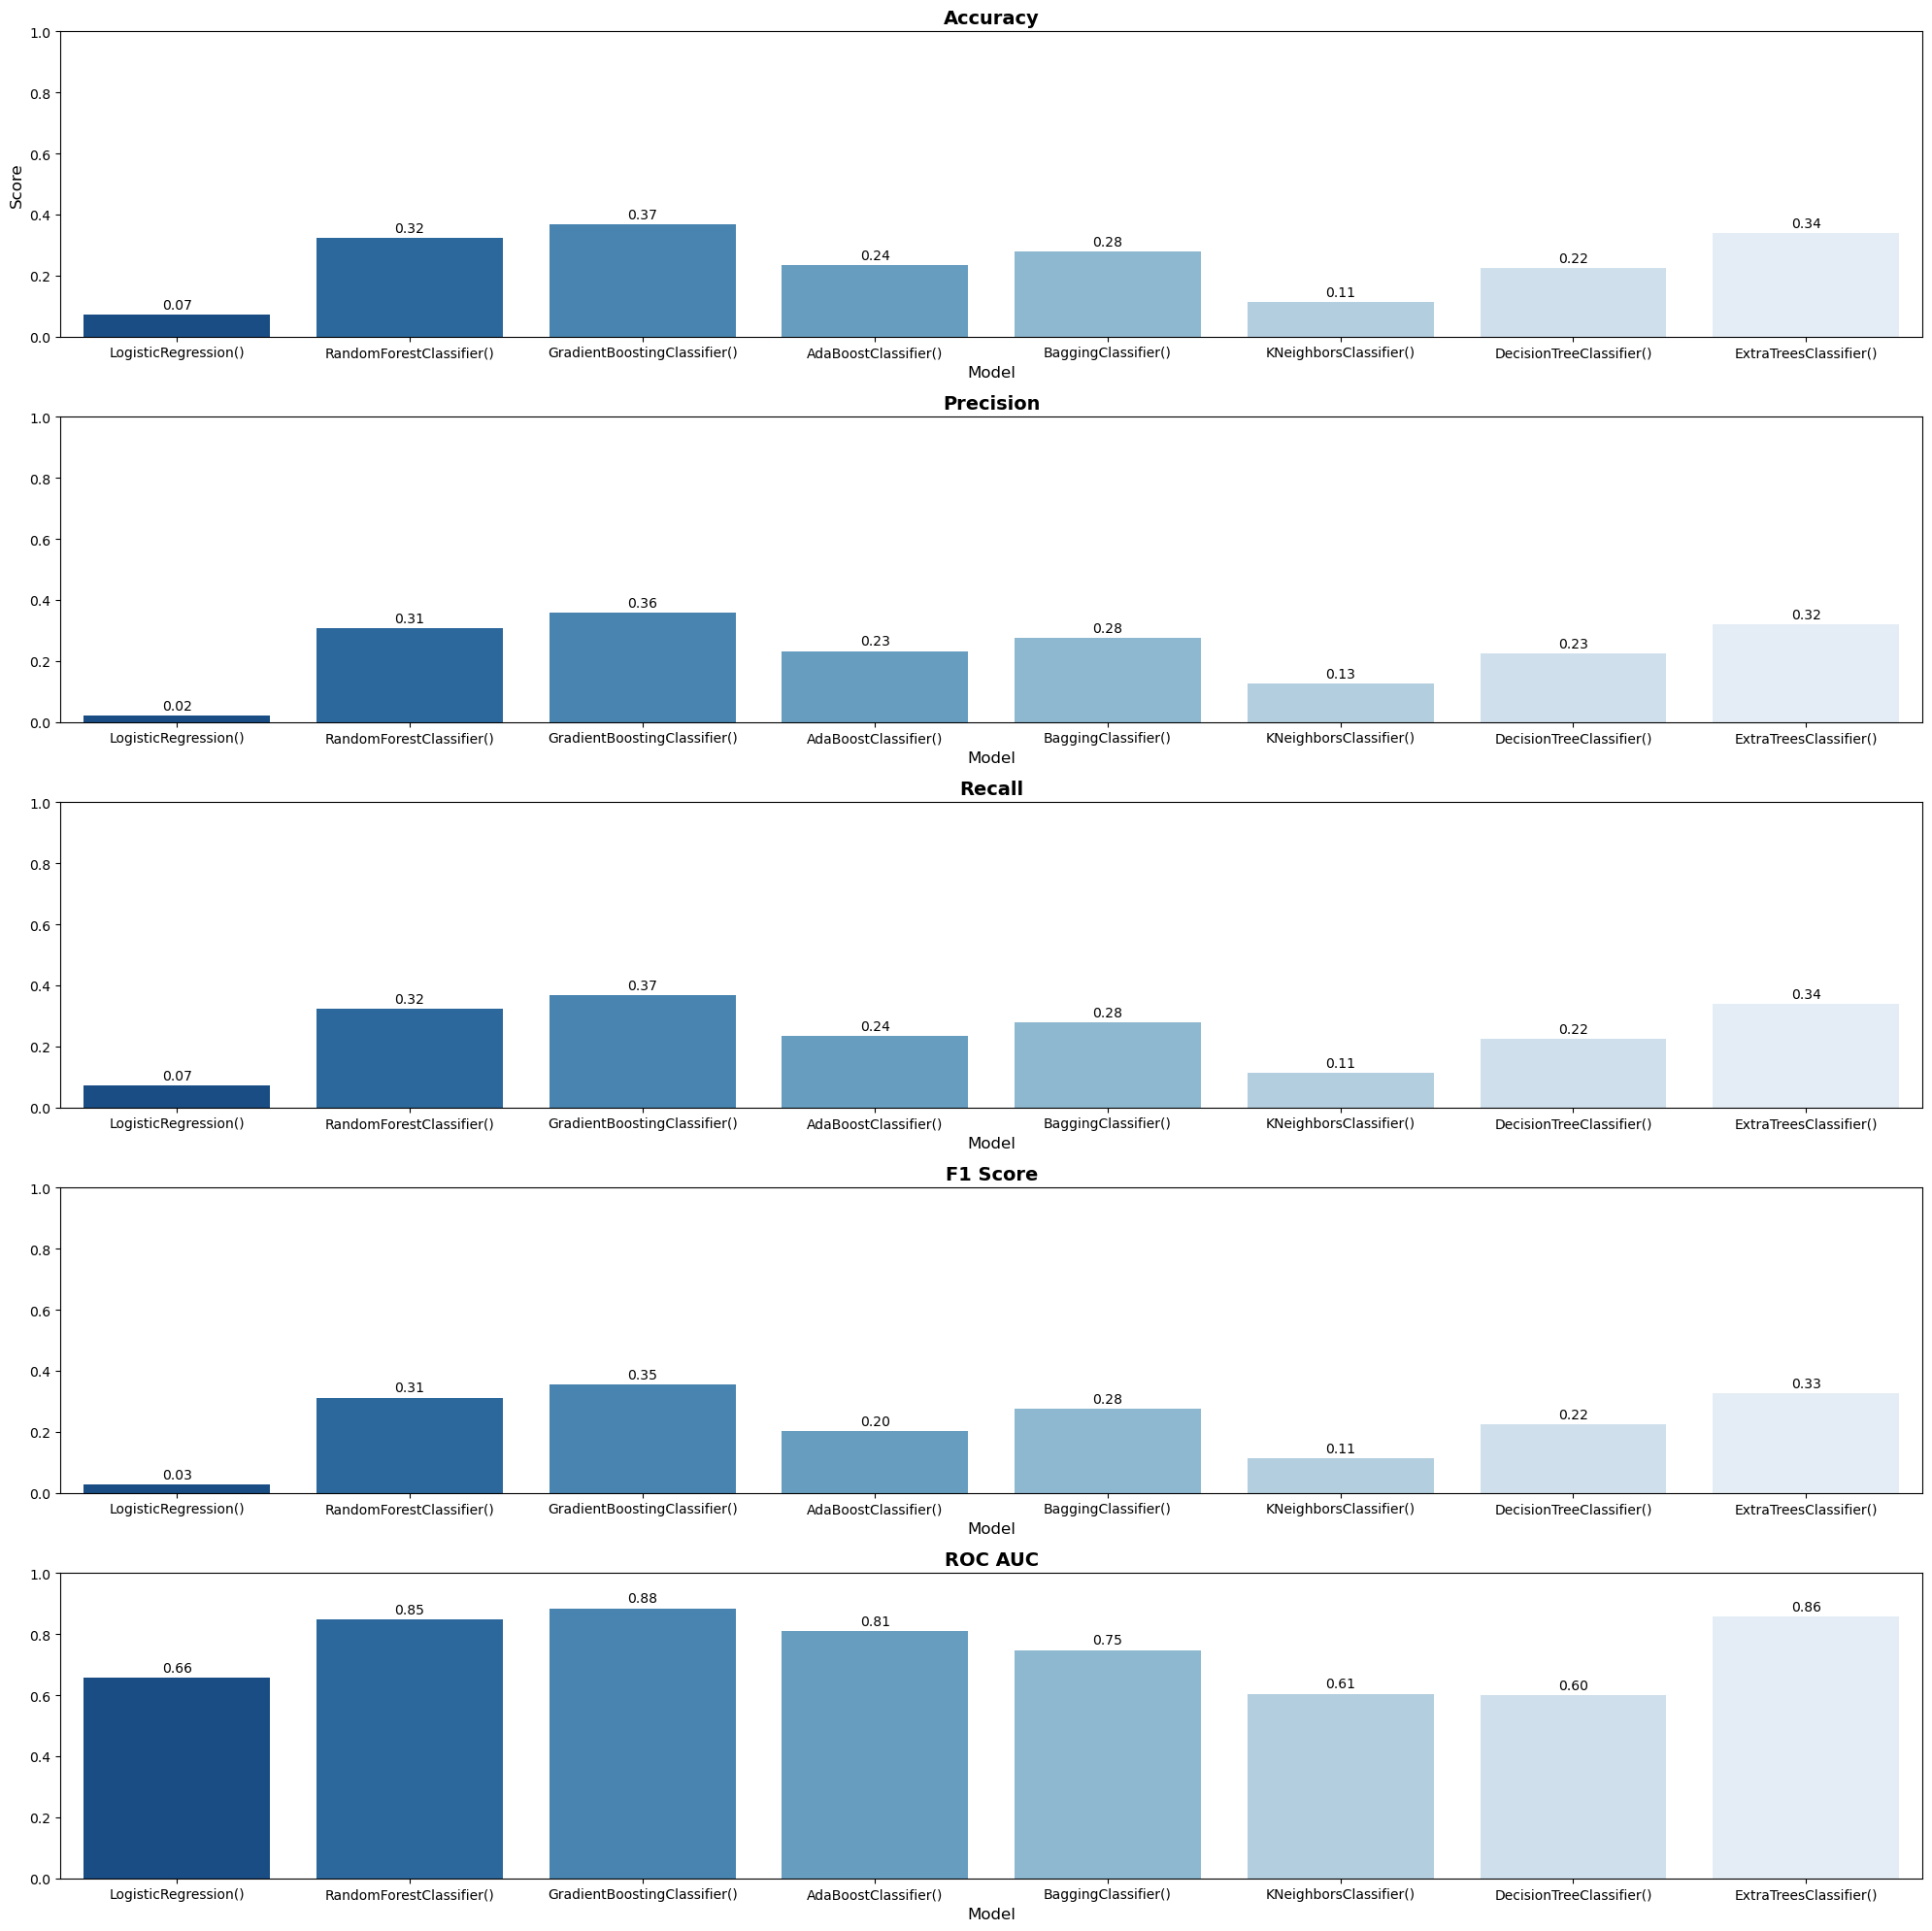

In [15]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


In [25]:
bp_media.isnull().sum()


track_id             0
wave_img_id      15834
wave_img_uuid    15834
sample_uuid          0
sample_start      2872
sample_end        2872
updated_on           0
genre_id             0
dtype: int64

In [26]:
bp_media.dropna(inplace=True)

In [27]:
bp_media.head()

,track_id,wave_img_id,wave_img_uuid,sample_uuid,sample_start,sample_end,updated_on,genre_id
0,17767172,34401296.0,09d00050-0a43-42f1-bb6e-c22bf9591a80,09d00050-0a43-42f1-bb6e-c22bf9591a80,172732.0,292732.0,2023-09-14 16:19:56,99
1,17775434,34430784.0,b9509b0f-2b7d-4254-84df-cc53eded7904,b9509b0f-2b7d-4254-84df-cc53eded7904,163532.0,283532.0,2023-09-14 16:19:56,99
2,17800962,34520332.0,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,157108.0,277108.0,2023-09-14 16:19:56,99
3,17610335,33799612.0,93747c55-cfb1-4df5-9c6a-ce9f5751983f,93747c55-cfb1-4df5-9c6a-ce9f5751983f,162976.0,282976.0,2023-09-14 16:19:56,99
4,17610338,33799613.0,e104a0f7-dfb7-4e10-8ed3-056e018c9775,e104a0f7-dfb7-4e10-8ed3-056e018c9775,174826.0,294826.0,2023-09-14 16:19:56,99


In [76]:
len(bp_media['genre_name'].unique())

32

In [106]:
sampled_data = bp_media.sample(n=10000, random_state=42)

In [132]:
# Function to download and process images from URLs, and collect error IDs
def load_images_from_url(df, img_column, target_size=(450, 75)):
    images = []
    failed_images = []  # List to store IDs of failed image downloads
    base_url = "https://geo-media.beatport.com/image_size/1500x250/"  # Replace with actual base URL if needed
    
    for img_id in df[img_column]:
        # Construct full image URL
        img_url = f"{base_url}{img_id}.png"
        try:
            # Send a request to download the image
            response = requests.get(img_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Open the image from the response content
            img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB
            img = img.resize(target_size)  # Resize to the target size
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_id}: {e}")
            failed_images.append(img_id)  # Add the image ID to the failed list
    
    return np.array(images), failed_images

# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')

# Check which images failed to load
if failed_image_ids:
    print(f"The following images failed to load: {failed_image_ids}")
else:
    print("All images loaded successfully.")


Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png
Error loading image 16fe20f8-7a5f-41ab-9976-0611dface0ab: 404 Cli

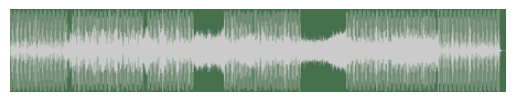

In [133]:
# Get the image at the specified index
img = image_data[36]

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [134]:
# Normalize the image data
image_data = image_data / 255.0

In [135]:
# Check how many unique genres you have in the dataset
print(sampled_data['genre_name'].nunique())  # Should return 32

# Check the distribution of genre IDs
print(sampled_data['genre_name'].value_counts())

32
genre_name
Electronica                             1269
House                                   1113
Techno (Peak Time / Driving)            1070
Tech House                               944
Deep House                               823
Progressive House                        541
Mainstage                                475
Dance / Electro Pop                      444
Minimal / Deep Tech                      437
Trance (Main Floor)                      402
Drum & Bass                              372
Trap / Wave                              305
Psy-Trance                               209
Melodic House & Techno                   180
Breaks / Breakbeat / UK Bass             176
Hard Dance / Hardcore                    172
Indie Dance                              168
Dubstep                                  155
Techno (Raw / Deep / Hypnotic)           120
Nu Disco / Disco                         119
Organic House / Downtempo                 95
Funky House                              

In [136]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Assuming the merged_data contains 'genre_name' instead of 'genre_id'
# Step 1: Label encode the genre names to convert them to numeric form
label_encoder = LabelEncoder()
genre_labels_encoded = label_encoder.fit_transform(sampled_data['genre_name'][:len(image_data)])

# Step 2: One-hot encode the numeric genre labels
num_classes = len(label_encoder.classes_)  # Get the number of unique genres
target_labels = to_categorical(genre_labels_encoded, num_classes=num_classes)



In [137]:
print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(target_labels)}")

Number of images: 9913
Number of labels: 9913


In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, target_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training set shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")


Training set shape (X_train): (7930, 75, 450, 3)
Training labels shape (y_train): (7930, 32)
Testing set shape (X_test): (1983, 75, 450, 3)
Testing labels shape (y_test): (1983, 32)


In [139]:
# Build a CNN model (same as before)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [141]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(75, 450, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block (increased filters)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block (increased filters)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block (newly added, with more filters)
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the data for Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))  # Increased units in Dense layer
model.add(Dropout(0.5))  # Keeping Dropout to prevent overfitting

# Output layer (softmax for multi-class classification)
model.add(Dense(len(sampled_data['genre_name'].unique()), activation='softmax'))

In [142]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
248/248 [==============================] - 103s 396ms/step - loss: 3.0161 - accuracy: 0.1146 - val_loss: 2.9384 - val_accuracy: 0.1185
Epoch 2/10
248/248 [==============================] - 97s 390ms/step - loss: 2.9415 - accuracy: 0.1180 - val_loss: 2.9390 - val_accuracy: 0.1220
Epoch 3/10
248/248 [==============================] - 95s 382ms/step - loss: 2.9323 - accuracy: 0.1230 - val_loss: 2.9291 - val_accuracy: 0.1220
Epoch 4/10
248/248 [==============================] - 95s 384ms/step - loss: 2.9330 - accuracy: 0.1173 - val_loss: 2.9219 - val_accuracy: 0.1220
Epoch 5/10
248/248 [==============================] - 96s 385ms/step - loss: 2.9257 - accuracy: 0.1274 - val_loss: 2.9216 - val_accuracy: 0.1220
Epoch 6/10
248/248 [==============================] - 104s 419ms/step - loss: 2.9277 - accuracy: 0.1188 - val_loss: 2.9246 - val_accuracy: 0.1220
Epoch 7/10
248/248 [==============================] - 113s 454ms/step - loss: 2.9249 - accuracy: 0.1226 - val_loss: 2.9213 - val

In [143]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

62/62 [==============================] - 5s 86ms/step - loss: 2.9206 - accuracy: 0.1220
Test Accuracy: 0.12203731387853622
